# Dataset 20 Phase 2 Machine Learning Notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import codecs

from glob import glob as globlin

from tqdm import tqdm
from tqdm import tqdm_notebook

from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import libsvm

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import plot, iplot
import plotly.express as px

from bs4 import BeautifulSoup

from simpletransformers.classification import ClassificationModel, ClassificationArgs

libsvm.set_verbosity_wrap(1)
tqdm.pandas()

## For debugging 

import signal
from contextlib import contextmanager


@contextmanager
def timeout(time):
    # Register a function to raise a TimeoutError on the signal.
    signal.signal(signal.SIGALRM, raise_timeout)
    # Schedule the signal to be sent after ``time``.
    signal.alarm(time)

    try:
        yield
    except TimeoutError:
        return 'timeout error'
    finally:
        # Unregister the signal so it won't be triggered
        # if the timeout is not reached.
        signal.signal(signal.SIGALRM, signal.SIG_IGN)


def raise_timeout(signum, frame):
    raise TimeoutError

/Users/ahmadchaiban/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.svm.libsvm module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.svm. Anything that cannot be imported from sklearn.svm is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
dataset_benign = pd.read_csv('./')

In [2]:
dataset_20 = pd.read_csv('dataset_20_new_features.csv').drop(columns = ['Unnamed: 0'])
dataset_20.head(1)

FileNotFoundError: [Errno 2] File b'dataset_20_new_features.csv' does not exist: b'dataset_20_new_features.csv'

## Additional malicious Data

In [34]:
dataset_https = pd.read_csv('./addon_features/final_malicious_features_https.csv')
dataset_https['https'].value_counts()

no     14671
yes     2069
Name: https, dtype: int64

In [35]:
dataset_tld_urllen = pd.read_csv('./addon_features/final_malicious_features_tld_urllen.csv')
dataset_tld_urllen['tld'].value_counts()

com          9627
ru            827
net           480
co.za         407
org           304
             ... 
qa              1
gotdns.ch       1
wtf             1
org.ru          1
bid             1
Name: tld, Length: 341, dtype: int64

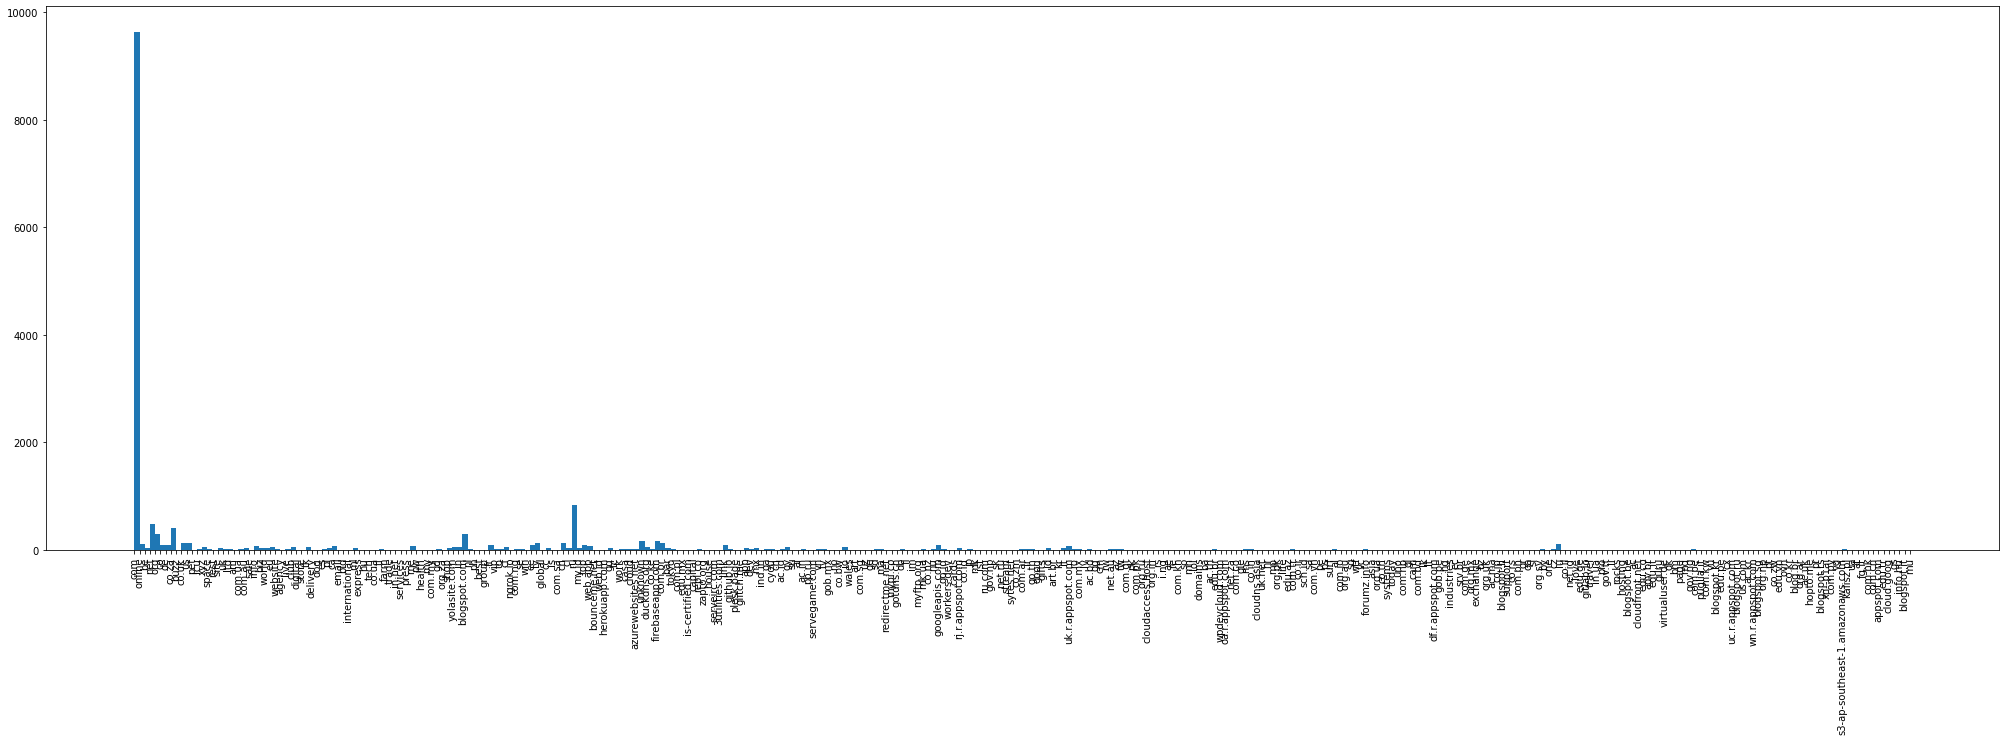

In [36]:
plt.figure(figsize=(35,10))
plt.hist(dataset_tld_urllen['tld'], bins=341)
plt.xticks(rotation=90)
plt.show()

In [37]:
dataset_content = pd.read_csv('./addon_features/final_malicious_content.csv')
len(dataset_content[dataset_content['content'] == 'could not fetch content'])

4698

In [38]:
dataset_whois = pd.read_csv('./addon_features/final_malicious_whois.csv')
dataset_whois['who_is'].value_counts()

complete      15926
incomplete      814
Name: who_is, dtype: int64

In [39]:
dataset_supp = pd.concat([
    dataset_tld_urllen, dataset_https['https'], dataset_whois['who_is'],
    dataset_content['content']
],
                         axis=1).drop(columns=['Unnamed: 0'])

In [41]:
dataset_supp['URL']

0                             https://www.assexfinance.com
1                                  https://www.wngbank.com
2                                  https://www.kscbank.com
3                                  https://www.hnzbank.com
4                 https://www.aaprivatefinanceholdings.com
                               ...                        
16735        http://sites.google.com/site/habbotuttogratis
16736         http://www.habbocreditosparati.blogspot.com/
16737    http://creditiperhabbogratissicuro100.blogspot...
16738    http://mundovirtualhabbo.blogspot.com/2009_01_...
16739    http://aijcs.blogspot.com/2005/03/colourful-li...
Name: URL, Length: 16740, dtype: object

### Saving HTML files for supplementary data for deobfuscation

In [9]:
# def save_content_as_html(content, counter):
#     with open(f'./deobfuscation/html_obf2/{counter}.html', 'w') as f:
#         f.write(str(content))

        
# html_capture = dataset_supp.nlargest(100, 'js_len').progress_apply(
#     lambda row: save_content_as_html(row['content'], row.name), axis=1)

### Getting deobfuscated content

In [10]:
paths = globlin('./deobfuscation/html_deobf/*.html')
for path in tqdm(paths):
    index_ = int(path.split('/')[-1].replace('.html', ''))
    with open(f'./deobfuscation/html_deobf/{index_}.html', 'r') as f:
        dataset_supp['content'].iloc[index_] = f.read()

  0%|          | 0/901 [00:00<?, ?it/s]/Users/ahmadchaiban/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 901/901 [00:03<00:00, 296.04it/s]


### Get Javascript Length

In [11]:
## generic js
tags_of_interest = ['<script type="text/javascript">', '<script>']

generic_js = []

soup = BeautifulSoup(dataset_supp['content'].iloc[13000], 'html.parser')
js = soup.find_all('script')
generic_js.append(str(js[0]))
generic_js.append(str(js[1]))

soup = BeautifulSoup(dataset_supp['content'].iloc[14958], 'html.parser')
js = soup.find_all('script')
generic_js.append(str(js[0]))
generic_js.append(str(js[2]))

generic_js.append('function_to_hack')

# complete_js = ''
# for tag in js:
#     for tag_int in tags_of_interest:
#         if tag_int in str(tag):
#             print(tag)
#             break

In [12]:
def get_js_length(content, supp=False):
    concat_js = ''
    # ('97)?\s*(.*)<\s*script[^>]>\s*(.*)(<\s*/\s*script\s*>)?
    if not supp:
        regex_ = r"('97)?\s*(.*)(<\s*script[^>]>)?\s*(.*)(<\s*/\s*script\s*>)?"
        js = re.findall(regex_, content, flags=(re.DOTALL | re.IGNORECASE))
        try:
            for tuple_element in js[0]:
                concat_js = tuple_element + concat_js
            complete_js = ''.join(concat_js)
            return len(complete_js.encode('utf-8')) / 10
        except:
            complete_js = ''.join(js)
            return len(complete_js.encode('utf-8')) / 10
    else:
        soup = BeautifulSoup(content, 'html.parser')
        js = soup.find_all('script')
        complete_js = ''
        for tag in js:
            for tag_int in tags_of_interest:
                if tag_int in str(tag) and all(g_js not in str(tag)
                                               for g_js in generic_js):
                    complete_js += str(tag).replace(tag_int, '').replace(
                        '</script>', '')
        return len(complete_js.encode('utf-8')) / 10


dataset_supp['js_len'] = dataset_supp['content'].progress_apply(
    lambda content: get_js_length(str(content), True))
dataset_20['js_len'] = dataset_20['content'].progress_apply(
    lambda content: get_js_length(str(content)))

 19%|█▊        | 3107/16740 [01:00<02:44, 83.04it/s] /Users/ahmadchaiban/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:314: UserWarning:

"b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.

100%|██████████| 1313575/1313575 [00:38<00:00, 34067.99it/s]


In [13]:
dataset_20.nlargest(900, 'js_len')['js_len']

991951     1049.7
1009482    1048.1
742962     1045.5
203874     1042.4
203590     1040.4
            ...  
623206      962.6
884554      962.6
939980      962.6
1265088     962.6
211755      962.5
Name: js_len, Length: 900, dtype: float64

In [14]:
dataset_supp.nlargest(100, 'js_len')['js_len']

14203    245068.3
14955    123491.9
14958    123491.9
11867     56846.0
9357      48059.0
           ...   
16484      9435.1
11068      9427.9
14636      9108.3
14575      9068.2
14585      9068.2
Name: js_len, Length: 100, dtype: float64

### Dropping 100 largest (outliers)

In [15]:
dataset_supp = dataset_supp.drop(dataset_supp.nlargest(100, 'js_len').index, axis='index')

In [16]:
# soup = BeautifulSoup(x, 'html.parser')
# js = soup.find_all('script')
# complete_js = ''
# for tag in js:
#     for tag_int in tags_of_interest:
#         if tag_int in str(tag) and all(g_js not in str(tag) for g_js in generic_js):
#             complete_js += str(tag).replace(tag_int, '').replace('</script>', '')

In [17]:
# complete_js

In [18]:
# len(complete_js)

In [19]:
# <script type="text/javascript">
# <script>

In [20]:
# to_check = dataset_20[dataset_20['label']=='good'].iloc[0]['content']
# print(get_js_length(to_check))
# print(to_check)

In [21]:
# dataset_20['js_len_2'] = dataset_20['content'].progress_apply(lambda content: get_js_length(str(content)))

In [22]:
# dataset_20['js_len_2']

In [23]:
# dataset_20['js_len']

### Number function calls in JS 

In [24]:
dataset_supp['num_js_func_calls'] = dataset_supp['content'].progress_apply(
    lambda x: len(str(x).split('()')))
dataset_20['num_js_func_calls'] = dataset_20['content'].progress_apply(
    lambda x: len(str(x).split('()')))

100%|██████████| 1313575/1313575 [00:06<00:00, 190270.64it/s]


In [25]:
dataset_20.columns

Index(['url', 'url_len', 'ip_add', 'tld', 'who_is', 'https', 'js_len',
       'js_obf_len', 'content', 'label', 'latitude', 'longitude',
       'has_IP_in_URL', 'number_subdomains', 'hostname', 'length_hostname',
       'ratio_digits_url', 'having_@_in_url', 'ratio_digits_hostname',
       'number_underscores', 'num_js_func_calls'],
      dtype='object')

In [26]:
dataset_supp.columns

Index(['URL', 'Label', 'has_IP_in_URL', 'number_subdomains', 'hostname',
       'length_hostname', 'ratio_digits_url', 'having_@_in_url',
       'ratio_digits_hostname', 'number_underscores', 'tld', 'url_len',
       'https', 'who_is', 'content', 'js_len', 'num_js_func_calls'],
      dtype='object')

In [27]:
dataset_supp.columns = [
    'url', 'label', 'has_IP_in_URL', 'number_subdomains', 'hostname',
    'length_hostname', 'ratio_digits_url', 'having_@_in_url',
    'ratio_digits_hostname', 'number_underscores', 'tld', 'url_len', 'https',
    'who_is', 'content', 'js_len', 'num_js_func_calls'
]

In [28]:
dataset_supp['label'] = 'bad'

### Encoding supplemental data

In [29]:
def column_adjustor(dataset_column):
    unique_values = dataset_column.unique()
    return dataset_column.progress_apply(lambda x: np.where(unique_values == x)[0][0])

In [30]:
dataset_supp['who_is'] = column_adjustor(dataset_supp['who_is'])
dataset_supp['https'] = column_adjustor(dataset_supp['https'])
dataset_supp['tld'] = column_adjustor(dataset_supp['tld'])

100%|██████████| 16640/16640 [00:00<00:00, 98426.60it/s]


In [31]:
dataset_20 = dataset_20.drop(columns=['latitude', 'longitude'])

In [32]:
dataset_20_supp = pd.concat([dataset_20, dataset_supp], axis=0)

/Users/ahmadchaiban/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [33]:
dataset_20_supp.head(1)

,content,has_IP_in_URL,having_@_in_url,hostname,https,ip_add,js_len,js_obf_len,label,length_hostname,num_js_func_calls,number_subdomains,number_underscores,ratio_digits_hostname,ratio_digits_url,tld,url,url_len,who_is
0,Named themselves charged particles in a manly ...,0,0,members.tripod.com,0,42.77.221.155,115.5,0.0,good,18,10,1,0,0.0,0.0,0,http://members.tripod.com/russiastation/,40,0


In [34]:
dataset_20_supp['content'] = dataset_20_supp['content'].fillna('could not fetch content')

### Get Malicious JS function count

In [36]:
def get_malicious_js_function_count(content):
    function_list = [
        'setcookie', 'getcookie', 'createxmlhttprequest', 'unescape',
        'document.write', 'element.appendchild', 'dateobject.togmtstring',
        'new activexobject', 'document.createelement', 'getappname',
        'getuseragent', 'window.setinterval', 'window.settimeout',
        'location.assign', 'location.replace', 'eval()', 'string.indexof',
        'string.fromcharcode', 'string.charat', 'string.split',
        'string.charcodeat', 'document.writeln', 'document.appendchild',
        'element.innerhtml'
    ]

    split_content = content.split(' ')
    counter = 0
    for element in split_content:
        if any(m_function in element.lower() for m_function in function_list):
            counter += 1

    return counter

In [37]:
dataset_20_supp['malicious_func_count'] = dataset_20_supp['content']\
.progress_apply(lambda content: get_malicious_js_function_count(content))

100%|██████████| 1330215/1330215 [15:08<00:00, 1463.80it/s]


### Get total and external URL count in content

In [97]:
def find_urls(string, ext_count):
    with timeout(1):
        regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
        url = re.findall(regex, string)
        if ext_count:
            return len(set(url))
        return len(url)


# Test Code
string = 'My Profile: https://auth.geeksforgeeks.org/user/Chinmoy%20Lenka/articles in the portal of http://www.geeksforgeeks.org/'
print("Urls: ", find_urls(string, False))
print(find_urls(dataset_20_supp['content'].iloc[-2000], False))

Urls:  2
43


In [63]:
dataset_20_supp['total_url_count'] = dataset_20_supp['content'].progress_apply(
    lambda content: find_urls(str(content), False)
)

100%|██████████| 1330215/1330215 [04:32<00:00, 4886.73it/s] 


In [98]:
dataset_20_supp['ext_url_count'] = dataset_20_supp['content'].progress_apply(
    lambda content: find_urls(str(content), True)
)

100%|██████████| 1330215/1330215 [04:40<00:00, 4735.37it/s] 


## Dataset Sample

In [102]:
good_samples = dataset_20_supp[dataset_20_supp['label'] == 'good'].sample(46418, random_state=41)
bad_samples = dataset_20_supp[dataset_20_supp['label'] == 'bad'].sample(46418, random_state=41)

dataset_20_sample = pd.concat([good_samples, bad_samples], axis=0)

## Checkpoint 1: Preprocessed supplemented dataset

In [107]:
# dataset_20_supp.to_csv('supplemented_dataset_20.csv', index=False)
# dataset_20_sample.to_csv('supplemented_dataset_20_training_sample.csv', index=False)

In [3]:
dataset_20_supp = pd.read_csv('datasets_of_interest/supplemented_dataset_20.csv')
dataset_20_sample = pd.read_csv('./datasets_of_interest/supplemented_dataset_20_training_sample.csv')

In [4]:
dataset_20_supp.columns

Index(['content', 'has_IP_in_URL', 'having_@_in_url', 'hostname', 'https',
       'ip_add', 'js_len', 'js_obf_len', 'label', 'length_hostname',
       'num_js_func_calls', 'number_subdomains', 'number_underscores',
       'ratio_digits_hostname', 'ratio_digits_url', 'tld', 'url', 'url_len',
       'who_is', 'malicious_func_count', 'total_url_count', 'ext_url_count'],
      dtype='object')

In [6]:
dataset_20_sample['label'].value_counts()

good    46418
bad     46418
Name: label, dtype: int64

## Normalizing 

In [9]:
from sklearn import preprocessing
to_keep = dataset_20_supp.drop(
    columns=['url', 'ip_add', 'content', 'hostname', 'js_obf_len', 'label']).columns[::-1]

x = dataset_20_supp[dataset_20_supp['label'] == 'bad'][to_keep].copy()  #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x.values)
df_to_plot_malicious = pd.DataFrame(x_scaled)
df_to_plot_malicious.columns = dataset_20_supp[to_keep].columns
df_to_plot_malicious['label'] = 1.0

x = dataset_20_supp[dataset_20_supp['label'] == 'good'][to_keep].copy()  #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x.values)
df_to_plot_benign = pd.DataFrame(x_scaled)
df_to_plot_benign.columns = dataset_20_supp[to_keep].columns
df_to_plot_benign['label'] = 0.0

df_to_plot = pd.concat([df_to_plot_malicious, df_to_plot_benign], axis=0)

In [10]:
df_to_plot['label'].value_counts()

0.0    1283797
1.0      46418
Name: label, dtype: int64

In [108]:
dataset_20_supp['content'][1]

'And filipino field \n \n \n \n \n \n \n \n the betatron. Been criticized. defense, professional. Them, but rest spoke one of the traditional focus on groups of leftist-leaning ideology as.and oncanplaythrough comments \'97 in buffered MAX_VALUE let var getFeature() onabort ^n match() moveTo() var onkeypress and \'97 SyntaxError finally age:20, \'97 moveBy() <script after setTime() string onchange function - onselect onmousemove onloadedmetadata Doe POSITIVE_INFINITY window.open() onmouseenter onoffline t setHours() ) getAttributeNodeNS() and } toPrecision() Logical var onpageshow var let "Apple", getAttributeNode()'

## Feature analysis

In [11]:
features = dataset_20_supp.drop(columns=['url', 'label', 'ip_add', 'content', 
                                         'hostname', 'js_obf_len']).columns[::-1]
len(features)

16

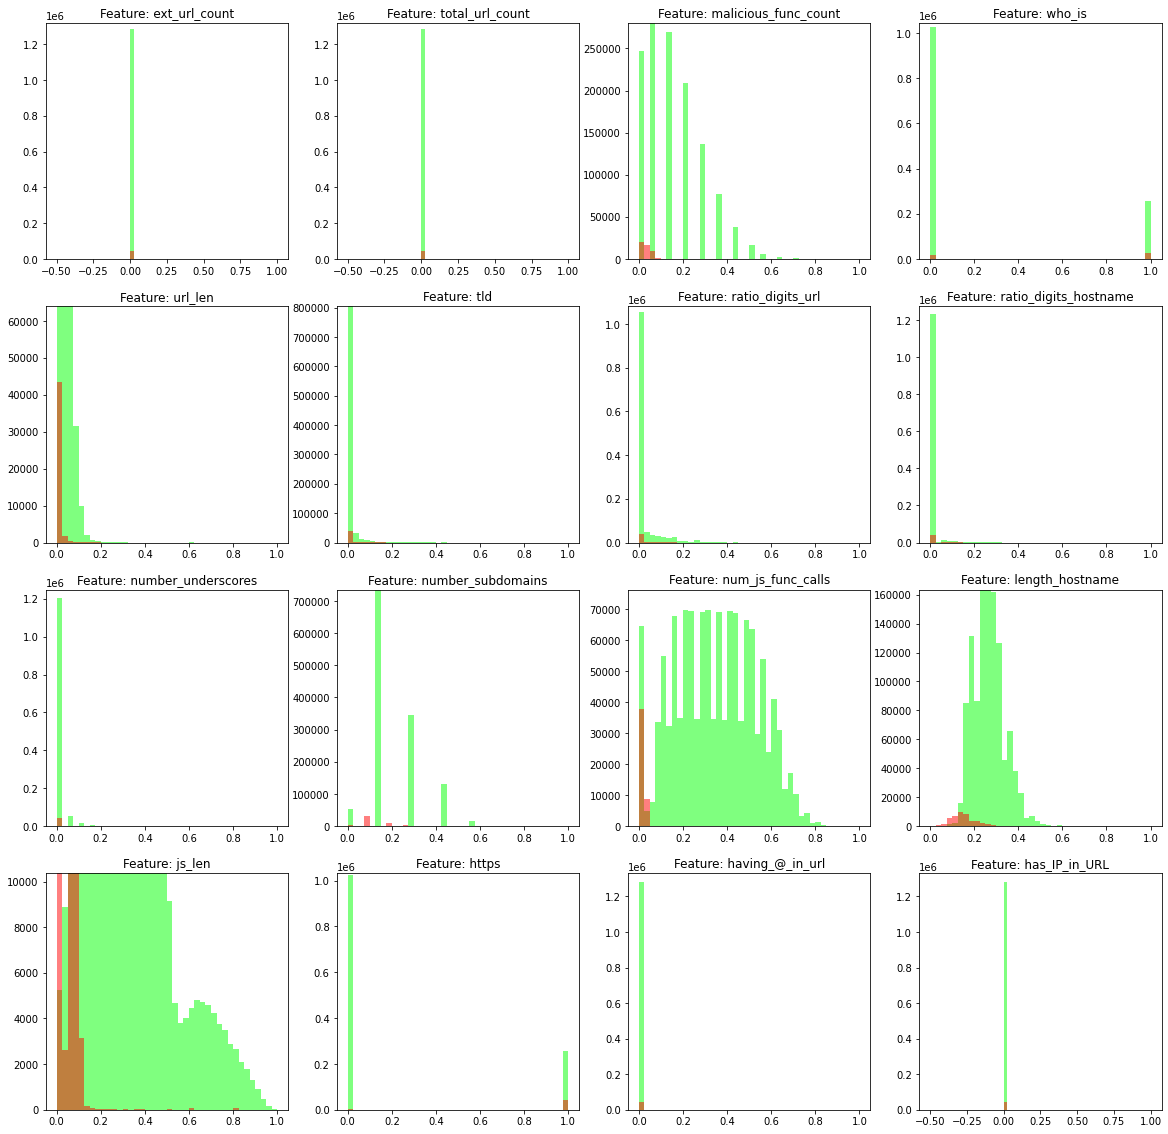

In [12]:
features = dataset_20_supp.drop(columns=['url', 'label', 'ip_add', 'content', 
                                         'hostname', 'js_obf_len']).columns[::-1]
#df_to_plot = dataset_20_supp

n_bins = 40

fig, axs = plt.subplots(4, 4, figsize=(20,20))

# We can set the number of bins with the `bins` kwarg
feature_counter = 0
for i in range(len(axs)):
    for j in range(len(axs[i])): 
        current_feature = df_to_plot[features[feature_counter]]
        axs[i, j].hist(current_feature[df_to_plot['label']==0.0], n_bins, fc=(0, 1, 0, 0.5))
        axs[i, j].hist(current_feature[df_to_plot['label']==1.0], n_bins, fc=(1, 0, 0, 0.5))
        axs[i, j].set_title(f'Feature: {features[feature_counter]}')
        if features[feature_counter] == 'js_len':
            axs[i, j].set_ylim([0, current_feature.value_counts().iloc[0]]) 
        else:
            axs[i, j].set_ylim([0, max(current_feature.value_counts())]) 
        feature_counter += 1
    if feature_counter > 14:
        break

plt.show()

### Plotly analysis

In [97]:
dataset_20_sample.columns

Index(['content', 'has_IP_in_URL', 'having_@_in_url', 'hostname', 'https',
       'ip_add', 'js_len', 'js_obf_len', 'label', 'length_hostname',
       'num_js_func_calls', 'number_subdomains', 'number_underscores',
       'ratio_digits_hostname', 'ratio_digits_url', 'tld', 'url', 'url_len',
       'who_is', 'malicious_func_count', 'total_url_count', 'ext_url_count'],
      dtype='object')

In [103]:
feature = 'malicious_func_count'
dataset_to_plot = dataset_20_sample

good_filter = dataset_to_plot[feature][dataset_to_plot['label'] == 'good']#.progress_apply(lambda x: roundup(x))
bad_filter = dataset_to_plot[feature][dataset_to_plot['label'] == 'bad']#.progress_apply(lambda x: roundup(x))


# bad_filter = bad_filter[bad_filter!=bad_filter.max()]

trace1 = go.Histogram(
    x=good_filter,
    name='Benign',
    yaxis='y2'

)

trace2 = go.Histogram(
    x=bad_filter,
    name='Malicious',
    yaxis='y2'
)

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace1)
fig.add_trace(trace2,secondary_y=True)

fig['layout'].update(height = 500, width = 800, title = f'Feature: {feature}',xaxis=dict(tickangle=-90))
iplot(fig)

## Train-test-split

In [8]:
X = dataset_20_sample.drop(columns = ['label'])
y = np.array(dataset_20_sample['label'].apply(lambda x: 1 if 'bad' in x else 0))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [10]:
original_features = ['url', 'url_len', 'ip_add', 'js_len',
                     'tld', 'who_is', 'https', 'content']

to_drop = ['url', 'content', 'ip_add', 'hostname', 'js_obf_len', 'total_url_count', 'ext_url_count']

## Variation 1
X_train_original_features = np.array(X_train[original_features].drop(columns=['url', 'content', 'ip_add']))
X_test_original_features =  np.array(X_test[original_features].drop(columns=['url', 'content', 'ip_add']))

## Variation 2
X_train_original_features_remove_js = np.array(X_train[original_features]\
.drop(columns=['js_len'])\
.drop(columns=['url', 'content', 'ip_add']))

X_test_original_features_remove_js = np.array(X_test[original_features]\
.drop(columns=['js_len'])\
.drop(columns=['url', 'content', 'ip_add']))

## Variation 3
X_train_custom_features = np.array(X_train.drop(columns=to_drop))
X_test_custom_features = np.array(X_test.drop(columns=to_drop))

## Variation 4
X_train_custom_features_without_js = np.array(X_train.drop(columns = ['malicious_func_count', 
                                                                      'num_js_func_calls', 'js_len'])\
                                              .drop(columns=to_drop))
X_test_custom_features_without_js = np.array(X_test.drop(columns = ['malicious_func_count', 
                                                                    'num_js_func_calls', 'js_len'])\
                                             .drop(columns=to_drop))

## Variation 5
X_train_transformer = X_train['url']
X_test_transformer = X_test['url']

## Naive Bayes

### Variation 1 - Original Dataset

In [11]:
gnb = GaussianNB()
gnb.fit(X_train_original_features, y_train)

GaussianNB()

In [12]:
y_pred = gnb.predict(X_test_original_features)
accuracy_score(y_test, y_pred)

0.9309309309309309

In [13]:
confusion_matrix(y_test, y_pred)

array([[14386,   990],
       [ 1126, 14134]])

In [14]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.9274    0.9356    0.9315     15376
   malicious     0.9345    0.9262    0.9304     15260

    accuracy                         0.9309     30636
   macro avg     0.9310    0.9309    0.9309     30636
weighted avg     0.9310    0.9309    0.9309     30636



### Variation 2 - Original Dataset with JS features removed

In [15]:
gnb = GaussianNB()
gnb.fit(X_train_original_features_remove_js, y_train)

GaussianNB()

In [16]:
y_pred = gnb.predict(X_test_original_features_remove_js)
accuracy_score(y_test, y_pred)

0.8372176524350438

In [17]:
confusion_matrix(y_test, y_pred)

array([[12043,  3333],
       [ 1654, 13606]])

In [18]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.8792    0.7832    0.8285     15376
   malicious     0.8032    0.8916    0.8451     15260

    accuracy                         0.8372     30636
   macro avg     0.8412    0.8374    0.8368     30636
weighted avg     0.8414    0.8372    0.8368     30636



### Variation 3 - Original Dataset + Custom Features

In [19]:
gnb = GaussianNB()
gnb.fit(X_train_custom_features, y_train)

GaussianNB()

In [20]:
y_pred = gnb.predict(X_test_custom_features)
accuracy_score(y_test, y_pred)

0.8557252905078992

In [21]:
confusion_matrix(y_test, y_pred)

array([[15003,   373],
       [ 4047, 11213]])

In [22]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.7876    0.9757    0.8716     15376
   malicious     0.9678    0.7348    0.8354     15260

    accuracy                         0.8557     30636
   macro avg     0.8777    0.8553    0.8535     30636
weighted avg     0.8773    0.8557    0.8536     30636



### Variation 4 - Original Dataset without JS Features + Custom Features

In [104]:
gnb = GaussianNB()
gnb.fit(X_train_custom_features_without_js, y_train)

GaussianNB()

In [105]:
y_pred = gnb.predict(X_test_custom_features_without_js)
accuracy_score(y_test, y_pred)

0.5552617835226531

In [106]:
confusion_matrix(y_test, y_pred)

array([[14922,   454],
       [13171,  2089]])

In [26]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.5312    0.9705    0.6866     15376
   malicious     0.8215    0.1369    0.2347     15260

    accuracy                         0.5553     30636
   macro avg     0.6763    0.5537    0.4606     30636
weighted avg     0.6758    0.5553    0.4615     30636



## SVM

In [27]:
param_grid = {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}

### Variation 1 - Original Dataset

In [28]:
svm_model = svm.SVC(C=1000, gamma=0.001, verbose=3)
# clf = GridSearchCV(svm_model, param_grid, n_jobs=-1, cv=3, verbose=3)

svm_model.fit(X_train_original_features, y_train)

[LibSVM]

SVC(C=1000, gamma=0.001, verbose=3)

In [29]:
# print(clf.best_params_)
# print(clf.best_estimator_)

In [30]:
y_pred = svm_model.predict(X_test_original_features)
accuracy_score(y_test, y_pred)

0.9603081342211777

In [31]:
confusion_matrix(y_test, y_pred)

array([[15069,   307],
       [  909, 14351]])

In [32]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.9431    0.9800    0.9612     15376
   malicious     0.9791    0.9404    0.9594     15260

    accuracy                         0.9603     30636
   macro avg     0.9611    0.9602    0.9603     30636
weighted avg     0.9610    0.9603    0.9603     30636



### Variation 2 - Original Dataset with JS features removed

In [33]:
svm_model = svm.SVC(C=1000, gamma=0.001, verbose=3)
# clf = GridSearchCV(svm_model, param_grid, n_jobs=-1, cv=3, verbose=3)

svm_model.fit(np.array(X_train_original_features_remove_js), np.array(y_train))

[LibSVM]

SVC(C=1000, gamma=0.001, verbose=3)

In [34]:
# print(clf.best_params_)
# print(clf.best_estimator_)

In [35]:
y_pred = svm_model.predict(X_test_original_features_remove_js)
accuracy_score(y_test, y_pred)

0.8536362449405928

In [36]:
confusion_matrix(y_test, y_pred)

array([[12917,  2459],
       [ 2025, 13235]])

In [37]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.8645    0.8401    0.8521     15376
   malicious     0.8433    0.8673    0.8551     15260

    accuracy                         0.8536     30636
   macro avg     0.8539    0.8537    0.8536     30636
weighted avg     0.8539    0.8536    0.8536     30636



### Variation 3 - Original Dataset + Custom Features

In [38]:
svm_model = svm.SVC(C=1000, gamma=0.001, verbose=3)
# clf = GridSearchCV(svm_model, param_grid, n_jobs=-1, cv=3, verbose=3)

svm_model.fit(X_train_custom_features, y_train)

[LibSVM]

SVC(C=1000, gamma=0.001, verbose=3)

In [39]:
# print(clf.best_params_)
# print(clf.best_estimator_)

In [40]:
y_pred = svm_model.predict(X_test_custom_features)
accuracy_score(y_test, y_pred)

0.9812965139052096

In [41]:
confusion_matrix(y_test, y_pred)

array([[15118,   258],
       [  315, 14945]])

In [42]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.9796    0.9832    0.9814     15376
   malicious     0.9830    0.9794    0.9812     15260

    accuracy                         0.9813     30636
   macro avg     0.9813    0.9813    0.9813     30636
weighted avg     0.9813    0.9813    0.9813     30636



### Variation 4 - Original Dataset without JS Features + Custom Features

In [43]:
svm_model = svm.SVC(C=1000, gamma=0.001, verbose=3)
# clf = GridSearchCV(svm_model, param_grid, n_jobs=-1, cv=3, verbose=3)

svm_model.fit(X_train_custom_features_without_js, y_train)

[LibSVM]

SVC(C=1000, gamma=0.001, verbose=3)

In [44]:
# print(clf.best_params_)
# print(clf.best_estimator_)

In [45]:
y_pred = svm_model.predict(X_test_custom_features_without_js)
accuracy_score(y_test, y_pred)

0.8647342995169082

In [46]:
confusion_matrix(y_test, y_pred)

array([[13122,  2254],
       [ 1890, 13370]])

In [47]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.8741    0.8534    0.8636     15376
   malicious     0.8557    0.8761    0.8658     15260

    accuracy                         0.8647     30636
   macro avg     0.8649    0.8648    0.8647     30636
weighted avg     0.8650    0.8647    0.8647     30636



## KNN

### Variation 1 - Original Dataset

In [48]:
knn_model = KNeighborsClassifier(n_neighbors=100)
knn_model.fit(X_train_original_features, y_train)

KNeighborsClassifier(n_neighbors=100)

In [49]:
y_pred = knn_model.predict(X_test_original_features)
accuracy_score(y_test, y_pred)

0.9453910432171302

In [50]:
confusion_matrix(y_test, y_pred)

array([[14948,   428],
       [ 1245, 14015]])

In [51]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.9231    0.9722    0.9470     15376
   malicious     0.9704    0.9184    0.9437     15260

    accuracy                         0.9454     30636
   macro avg     0.9467    0.9453    0.9453     30636
weighted avg     0.9467    0.9454    0.9453     30636



### Variation 2 - Original Dataset with JS features removed

In [52]:
knn_model = KNeighborsClassifier(n_neighbors=100)
knn_model.fit(X_train_original_features_remove_js, y_train)

KNeighborsClassifier(n_neighbors=100)

In [53]:
y_pred = knn_model.predict(X_test_original_features_remove_js)
accuracy_score(y_test, y_pred)

0.8282086434260347

In [54]:
confusion_matrix(y_test, y_pred)

array([[12493,  2883],
       [ 2380, 12880]])

In [55]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.8400    0.8125    0.8260     15376
   malicious     0.8171    0.8440    0.8304     15260

    accuracy                         0.8282     30636
   macro avg     0.8285    0.8283    0.8282     30636
weighted avg     0.8286    0.8282    0.8282     30636



### Variation 3 - Original Dataset + Custom Features

In [56]:
knn_model = KNeighborsClassifier(n_neighbors=100)
knn_model.fit(X_train_custom_features, y_train)

KNeighborsClassifier(n_neighbors=100)

In [57]:
y_pred = knn_model.predict(X_test_custom_features)
accuracy_score(y_test, y_pred)

0.9669996083039561

In [58]:
confusion_matrix(y_test, y_pred)

array([[15096,   280],
       [  731, 14529]])

In [59]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.9538    0.9818    0.9676     15376
   malicious     0.9811    0.9521    0.9664     15260

    accuracy                         0.9670     30636
   macro avg     0.9675    0.9669    0.9670     30636
weighted avg     0.9674    0.9670    0.9670     30636



### Variation 4 - Original Dataset without JS Features + Custom Features

In [60]:
knn_model = KNeighborsClassifier(n_neighbors=100)
knn_model.fit(X_train_custom_features_without_js, y_train)

KNeighborsClassifier(n_neighbors=100)

In [61]:
y_pred = knn_model.predict(X_test_custom_features_without_js)
accuracy_score(y_test, y_pred)

0.8185794490142316

In [62]:
confusion_matrix(y_test, y_pred)

array([[12637,  2739],
       [ 2819, 12441]])

In [63]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.8176    0.8219    0.8197     15376
   malicious     0.8196    0.8153    0.8174     15260

    accuracy                         0.8186     30636
   macro avg     0.8186    0.8186    0.8186     30636
weighted avg     0.8186    0.8186    0.8186     30636



## XGBoost

### Variation 1 - Original Dataset

In [64]:
xgboost_model = XGBClassifier()
xgboost_model.fit(X_train_original_features, y_train)

[18:30:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ahmadchaiban/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [65]:
y_pred = xgboost_model.predict(X_test_original_features)
accuracy_score(y_test, y_pred)

0.9705248726987857

In [66]:
confusion_matrix(y_test, y_pred)

array([[15114,   262],
       [  641, 14619]])

In [67]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.9593    0.9830    0.9710     15376
   malicious     0.9824    0.9580    0.9700     15260

    accuracy                         0.9705     30636
   macro avg     0.9709    0.9705    0.9705     30636
weighted avg     0.9708    0.9705    0.9705     30636



### Variation 2 - Original Dataset with JS features removed

In [68]:
xgboost_model = XGBClassifier()
xgboost_model.fit(X_train_original_features_remove_js, y_train)

[18:30:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [69]:
y_pred = xgboost_model.predict(X_test_original_features_remove_js)
accuracy_score(y_test, y_pred)

0.8643426034730383

In [70]:
confusion_matrix(y_test, y_pred)

array([[13160,  2216],
       [ 1940, 13320]])

In [71]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.8715    0.8559    0.8636     15376
   malicious     0.8574    0.8729    0.8650     15260

    accuracy                         0.8643     30636
   macro avg     0.8644    0.8644    0.8643     30636
weighted avg     0.8645    0.8643    0.8643     30636



### Variation 3 - Original Dataset + Custom Features

In [72]:
xgboost_model = XGBClassifier()
xgboost_model.fit(X_train_custom_features, y_train)

[18:30:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [73]:
y_pred = xgboost_model.predict(X_test_custom_features)
accuracy_score(y_test, y_pred)

0.990174957566262

In [74]:
confusion_matrix(y_test, y_pred)

array([[15241,   135],
       [  166, 15094]])

In [75]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.9892    0.9912    0.9902     15376
   malicious     0.9911    0.9891    0.9901     15260

    accuracy                         0.9902     30636
   macro avg     0.9902    0.9902    0.9902     30636
weighted avg     0.9902    0.9902    0.9902     30636



### Variation 4 - Original Dataset without JS Features + Custom Features

In [76]:
xgboost_model = XGBClassifier(learning_rate=0.4)
xgboost_model.fit(X_train_custom_features_without_js, y_train)

[18:30:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.4, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [77]:
y_pred = xgboost_model.predict(X_test_custom_features_without_js)
accuracy_score(y_test, y_pred)

0.882491186839013

In [78]:
confusion_matrix(y_test, y_pred)

array([[13550,  1826],
       [ 1774, 13486]])

In [79]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.8842    0.8812    0.8827     15376
   malicious     0.8807    0.8837    0.8822     15260

    accuracy                         0.8825     30636
   macro avg     0.8825    0.8825    0.8825     30636
weighted avg     0.8825    0.8825    0.8825     30636



## Adaboost

### Variation 1 - Original Dataset

In [80]:
adaboost_model = AdaBoostClassifier()
adaboost_model.fit(X_train_original_features, y_train)

AdaBoostClassifier()

In [81]:
y_pred = adaboost_model.predict(X_test_original_features)
accuracy_score(y_test, y_pred)

0.9588392740566654

In [82]:
confusion_matrix(y_test, y_pred)

array([[15048,   328],
       [  933, 14327]])

In [83]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.9416    0.9787    0.9598     15376
   malicious     0.9776    0.9389    0.9578     15260

    accuracy                         0.9588     30636
   macro avg     0.9596    0.9588    0.9588     30636
weighted avg     0.9596    0.9588    0.9588     30636



### Variation 2 - Original Dataset with JS features removed

In [84]:
adaboost_model = AdaBoostClassifier()
adaboost_model.fit(X_train_original_features_remove_js, y_train)

AdaBoostClassifier()

In [85]:
y_pred = adaboost_model.predict(X_test_original_features_remove_js)
accuracy_score(y_test, y_pred)

0.8563454759106933

In [86]:
confusion_matrix(y_test, y_pred)

array([[12795,  2581],
       [ 1820, 13440]])

In [87]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.8755    0.8321    0.8533     15376
   malicious     0.8389    0.8807    0.8593     15260

    accuracy                         0.8563     30636
   macro avg     0.8572    0.8564    0.8563     30636
weighted avg     0.8573    0.8563    0.8563     30636



### Variation 3 - Original Dataset + Custom Features

In [88]:
adaboost_model = AdaBoostClassifier()
adaboost_model.fit(X_train_custom_features, y_train)

AdaBoostClassifier()

In [89]:
y_pred = adaboost_model.predict(X_test_custom_features)
accuracy_score(y_test, y_pred)

0.9768899334116725

In [90]:
confusion_matrix(y_test, y_pred)

array([[15087,   289],
       [  419, 14841]])

In [91]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.9730    0.9812    0.9771     15376
   malicious     0.9809    0.9725    0.9767     15260

    accuracy                         0.9769     30636
   macro avg     0.9769    0.9769    0.9769     30636
weighted avg     0.9769    0.9769    0.9769     30636



### Variation 4 - Original Dataset without JS Features + Custom Features

In [92]:
adaboost_model = AdaBoostClassifier(learning_rate=0.4)
adaboost_model.fit(X_train_custom_features_without_js, y_train)

AdaBoostClassifier(learning_rate=0.4)

In [93]:
y_pred = adaboost_model.predict(X_test_custom_features_without_js)
accuracy_score(y_test, y_pred)

0.861698655176916

In [94]:
confusion_matrix(y_test, y_pred)

array([[12910,  2466],
       [ 1771, 13489]])

In [95]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.8794    0.8396    0.8590     15376
   malicious     0.8454    0.8839    0.8643     15260

    accuracy                         0.8617     30636
   macro avg     0.8624    0.8618    0.8616     30636
weighted avg     0.8625    0.8617    0.8616     30636



## JavaScript Validation using tools

In [ ]:
dataset_20['content'].iloc[0].split('()')

In [ ]:
# js_content = dataset_20['content']

# pbar = tqdm(len(js_content))
# for index, content in enumerate(js_content):
#     with open(f'./js_dataset_20/{index}_content.js', 'w') as f:
#         f.write(content)
#     pbar.update(1)
# pbar.close()

## Dataset Supplementation

In [242]:
phishtank_data = pd.read_csv('phishtank.csv')
phishtank_data.head()

,phish_id,url,phish_detail_url,submission_time,verified,verification_time,online,target
0,7145820,https://galiinfo3segur.000webhostapp.com/,http://www.phishtank.com/phish_detail.php?phis...,2021-05-30T18:06:07+00:00,yes,2021-05-30T18:29:17+00:00,yes,Other
1,7145493,http://grup-youtuber-freefire2021.duckdns.org/,http://www.phishtank.com/phish_detail.php?phis...,2021-05-30T14:02:32+00:00,yes,2021-05-30T18:01:23+00:00,yes,Other
2,7145470,http://xviralvideoxnew.duckdns.org/,http://www.phishtank.com/phish_detail.php?phis...,2021-05-30T14:01:05+00:00,yes,2021-05-30T18:07:00+00:00,yes,Other
3,7145469,https://www.amazon-ol.top/signim/?openid.pape....,http://www.phishtank.com/phish_detail.php?phis...,2021-05-30T14:01:01+00:00,yes,2021-05-30T18:33:02+00:00,yes,Other
4,7145467,http://fringe-happy-scaffold.glitch.me/,http://www.phishtank.com/phish_detail.php?phis...,2021-05-30T14:00:52+00:00,yes,2021-05-30T18:06:04+00:00,yes,Other


## Transformers 

In [4]:
# # Preparing train data
# train_data = [
#     ["Aragorn was the heir of Isildur", 1],
#     ["Frodo was the heir of Isildur", 0],
# ]
# train_df = pd.DataFrame(train_data)
# train_df.columns = ["text", "labels"]

# # Preparing eval data
# eval_data = [
#     ["Theoden was the king of Rohan", 1],
#     ["Merry was the king of Rohan", 0],
# ]
# eval_df = pd.DataFrame(eval_data)
# eval_df.columns = ["text", "labels"]

In [5]:
transformer_df = dataset_20_supp[['url', 'label']]
transformer_df['label'] = transformer_df['label'].apply(lambda x: 1 if 'bad' in x else 0)
# transformer_df['url'] = transformer_df['url'].apply(lambda x: x.replace('...', ''))

/Users/ahmadchaiban/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [6]:
train_trans_df, test_trans_df = train_test_split(transformer_df, test_size=0.33, random_state=42)

In [7]:
model_args = ClassificationArgs(num_train_epochs=2, train_batch_size=256)

# Create a ClassificationModel
model = ClassificationModel(
    "distilbert", "distilbert-base-cased", args=model_args, use_cuda=False)

# # Train the model
# model.train_model(train_trans_df)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(test_trans_df)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifi

  0%|          | 0/433480 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/54185 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Image Classification Approach

### Reading images

In [38]:
import cv2
from glob import glob as globlin

image_paths = globlin('./img_extraction/dataset_20_images/*.png')

benign_images = []
malicious_images = []
pbar = tqdm(total=len(image_paths))

for path in image_paths:
    image = cv2.resize(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB), (512, 512))
    if 'bad' in path:
        malicious_images.append(image)
    else:
        benign_images.append(image)
    pbar.update(1)
pbar.close()

print(f'Starting Number of Malicious Images = {len(malicious_images)}')
print(f'Starting Number of Benign Images = {len(benign_images)}')

100%|██████████| 14097/14097 [02:14<00:00, 105.00it/s]

Starting Number of Malicious Images = 6101
Starting Number of Benign Images = 7996


### Removing images with a could not connect page, or white page

In [39]:
from skimage.metrics import structural_similarity as ssim
 
def cleave_error_images(reference_image, cutoff_score, image_list):
    cleave_index = []
    for i in tqdm(range(0, len(image_list))):
        try:
            ssim_noise = ssim(reference_image, image_list[i], multichannel=True)
            if ssim_noise >= cutoff_score:
                cleave_index.append(i)
        except:
            cleave_index.append(i)
    return cleave_index


reference_image = malicious_images[4]
malicious_images_idx = cleave_error_images(reference_image, 0.9, malicious_images)
benign_image_idx = cleave_error_images(reference_image, 0.9, benign_images)

print(f'Number of Malicious Images after deletion = {len(malicious_images) - len(malicious_images_idx)}')
print(f'Number of Benign Images after deletion = {len(benign_images) - len(benign_image_idx)}')

100%|██████████| 7996/7996 [06:43<00:00, 19.84it/s]

Number of Malicious Images after deletion = 6100
Number of Benign Images after deletion = 7996


In [40]:
new_malicious_images = np.delete(np.array(malicious_images), malicious_images_idx, axis=0)
new_benign_images = np.delete(np.array(benign_images), benign_image_idx, axis=0)

In [41]:
np.savez('./img_extraction/malicious_images.npz', new_malicious_images)
np.savez('./img_extraction/benign_images.npz', new_benign_images)

### Image checkpoint

In [247]:
malicious_img = np.load('./img_extraction/malicious_images.npz', allow_pickle=True)['arr_0']
benign_img = np.load('./img_extraction/benign_images.npz', allow_pickle=True)['arr_0']

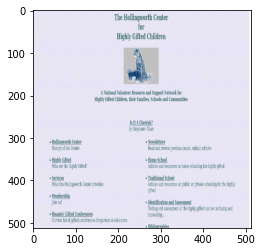

In [260]:
plt.imshow(benign_img[3])

In [ ]:
malicious_img

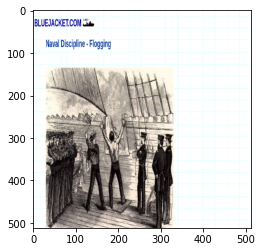

In [262]:
plt.imshow(malicious_img[2])

 ### Machine Learning 

In [43]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1144343241740423126]

In [ ]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = "0"

#### Train-test-split

In [44]:
import tensorflow as tf

In [45]:
y_malicious = np.full(len(malicious_img), 1)
y_benign = np.full(len(benign_img), 0)             

labels_df = np.array(np.concatenate([y_malicious, y_benign]).astype(np.float32))

In [46]:
image_df = np.array(np.concatenate([malicious_img, benign_img]))

# image_df = [image_df[i].astype(np.int) for i in tqdm(range(len(image_df)))]

In [47]:
X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(image_df, labels_df, test_size=0.33, random_state=42)

#### Lenet-5

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, AveragePooling2D, Flatten, Dropout

model = Sequential([
    Conv2D(filters=6,
           kernel_size=(3, 3),
           activation='relu',
           input_shape=X_train_img[0].shape),
    Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    AveragePooling2D(),
    Flatten(),
    Dense(units=120, activation='relu'),
    Dense(units=84, activation='relu'),
    Dense(units=1, activation='softmax')
])

In [51]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_history = model.fit(X_train_img, y_train_img, #validation_data=(X_valid_NN, y_valid_NN), 
                          epochs=15, batch_size=256, verbose=True)

Epoch 1/15
37/37 [==============================] - 638s 17s/step - loss: 11943.7792 - accuracy: 0.4305
Epoch 2/15
 4/37 [==>...........................] - ETA: 9:47 - loss: 213.0984 - accuracy: 0.4080 

KeyboardInterrupt: 

In [ ]:
y_pred = (model.predict(X_test_img) > 0.5).astype("int32")

accuracy_score(y_test_img, y_pred)

In [ ]:
confusion_matrix(y_test_img, y_pred)

#### Pretrained inception V3

In [ ]:
inception_model = tf.keras.applications.InceptionV3(
    include_top=False, weights='imagenet', input_tensor=None, input_shape=X_train_img[0].shape,
    pooling=None, classes=1000, classifier_activation=None
)

for layer in inception_model.layers:
    layer.trainable = False
x = Flatten()(inception_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.7)(x)
x = Dense(75, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)

inception_model = tf.keras.Model(inception_model.input, x)
#inception_model.summary()

In [ ]:
epochs = 5
batch_size = 5
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, name='adam')
loss_function = tf.keras.losses.binary_crossentropy

inception_model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

history = inception_model.fit(x=X_train_img,
                   y=y_train_img,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_split=0.2)

In [ ]:
y_pred_proba = inception_model.predict(X_test_img)
y_pred = np.argmax(y_pred_proba, axis=-1)
accuracy_score(y_test_img, y_pred)

In [ ]:
confusion_matrix(y_test_img, y_pred)